In [2]:
%pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc pandas scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:11, :].astype(float).values
X = X.T
# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1)
print('X.shape = ', X.shape, ', y.shape = ',y.shape)

# Rescale X to be within -pi to pi
X_min = np.min(X)
X_max = np.max(X)
X_rescaled = (X - X_min) / (X_max - X_min) * 2*(np.pi)
X = X_rescaled

from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print('X_train.shape = ', X_train.shape, ', X_test.shape = ', X_test.shape)

X.shape =  (72, 10) , y.shape =  (72,)
X_train.shape =  (57, 10) , X_test.shape =  (15, 10)


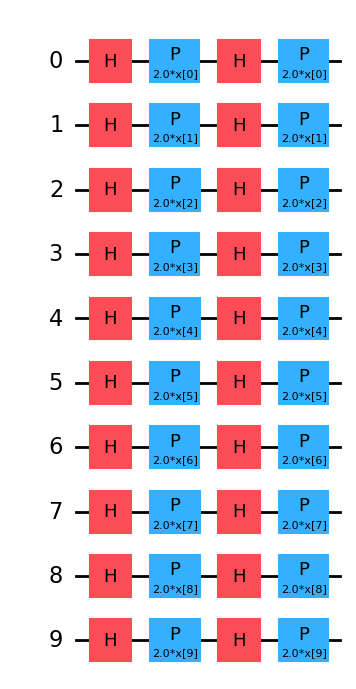

In [2]:
from qiskit.circuit.library import z_feature_map
from qiskit.circuit.library import efficient_su2
num_features = np.shape(X_train)[1]
num_qubits = int(num_features)
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
fm = z_feature_map(num_qubits, reps=2,parameter_prefix="x")
fm.draw("mpl")

training done
test matrix done


Text(0.5, 1.0, 'test matrix')

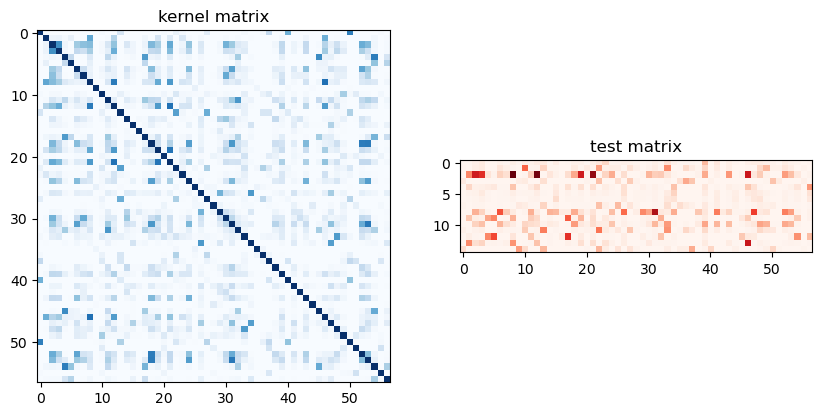

In [3]:
# Empty kernel matrix
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)
test_matrix = np.full((test_size, num_samples), np.nan)

# To use a simulator
from qiskit.primitives import StatevectorSampler
from qiskit.circuit.library import unitary_overlap
 
num_shots = 10000

sampler = StatevectorSampler()
 
for x1 in range(0, train_size):
    for x2 in range(x1 + 1, train_size):
        unitary1 = fm.assign_parameters(list(X_train[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        # These lines run the qiskit sampler primitive.
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        # Assign the probability of the 0 state to the kernel matrix, and the transposed element (since this is an inner product)
        kernel_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
        kernel_matrix[x2, x1] = counts.get(0, 0.0) / num_shots
    # Fill in on-diagonal elements with 1, again, since this is an inner-product corresponding to probability (or alter the code to check these entries and verify they yield 1)
    kernel_matrix[x1, x1] = 1
 
print("training done")
 
# Similar process to above, but for testing data.
for x1 in range(0, test_size):
    for x2 in range(0, train_size):
        unitary1 = fm.assign_parameters(list(X_test[x1]))
        unitary2 = fm.assign_parameters(list(X_train[x2]))
 
        # Create the overlap circuit
        overlap_circ = unitary_overlap(unitary1, unitary2)
        overlap_circ.measure_all()
 
        counts = (
            sampler.run([overlap_circ], shots=num_shots)
            .result()[0]
            .data.meas.get_int_counts()
        )
 
        test_matrix[x1, x2] = counts.get(0, 0.0) / num_shots
 
print("test matrix done")

# Visualisation Imports
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(
    np.asmatrix(kernel_matrix), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("kernel matrix")

axs[1].imshow(np.asmatrix(test_matrix), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("test matrix")

In [4]:
# import a support vector classifier from a classical ML package.
from sklearn.svm import SVC
 
# Specify that you want to use a pre-computed kernel matrix
qml_svc = SVC(kernel="precomputed")

# Feed in the pre-computed matrix and the labels of the training data. The classical algorithm gives you a fit.
qml_svc.fit(kernel_matrix, train_labels)
 
# Now use the .score to test your data, using the matrix of test data, and test labels as your inputs.
qml_score_train_kernel = qml_svc.score(kernel_matrix, train_labels)
print(f"Quantum SVC classification training accuracy: {qml_score_train_kernel}")
qml_score_test_kernel = qml_svc.score(test_matrix, test_labels)
print(f"Quantum SVC classification test accuracy: {qml_score_test_kernel}")

Quantum SVC classification training accuracy: 0.8596491228070176
Quantum SVC classification test accuracy: 0.6666666666666666


In [5]:
from sklearn.svm import SVC

svc = SVC()
_ = svc.fit(X_train, train_labels)  # suppress printing the return value
train_score_c = svc.score(X_train, train_labels)
test_score_c = svc.score(X_test, test_labels)


print(f"Classical SVC training accuracy: {train_score_c:.2f}")
print(f"Classical SVC test accuracy:     {test_score_c:.2f}")

Classical SVC training accuracy: 0.68
Classical SVC test accuracy:     0.67
